# Lecture 2: Autoregressive Models


## 1. Recap: Probability Distributions

**Formal**


- Discrete: $X ∈ \{1,…,K\}, \; P(X=i)=p_i, \; \sum_i p_i=1.$
- Continuous: $\int p(x) dx = 1, \; p(x) ≥ 0.$
- Multivariate: $p(\mathbf{x}) = p(x_1,…,x_d).$


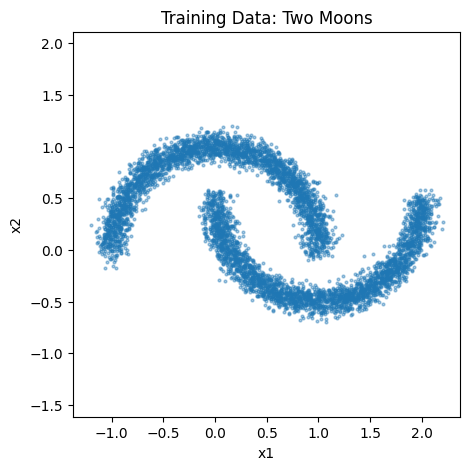

In [ ]:
# Training data: Two-Moons Distribution
# -------------------------------------
# We'll use this as our "true" data distribution p(x).
# Later, we'll fit a generative model to approximate it.

import math, torch
import matplotlib.pyplot as plt

torch.manual_seed(0)

def sample_two_moons(n=5000, noise=0.07):
    theta1 = torch.rand(n//2) * math.pi
    moon1 = torch.stack([torch.cos(theta1), torch.sin(theta1)], dim=1)
    theta2 = torch.rand(n - n//2) * math.pi
    moon2 = torch.stack([1.0 - torch.cos(theta2), 1.0 - torch.sin(theta2) - 0.5], dim=1)
    X = torch.cat([moon1, moon2], dim=0)
    X += noise * torch.randn_like(X)
    return X

# Generate samples
data_x = sample_two_moons(6000, noise=0.07)

# Plot
plt.figure(figsize=(5,5))
plt.scatter(data_x[:,0].numpy(), data_x[:,1].numpy(), s=4, alpha=0.4)
plt.title("Training Data: Two Moons")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()


---
## ✨ Key Concept: Two Different Tasks in Generative Models
---

A generative model defines a distribution $p_\theta(x)$.  
But there are **two distinct interfaces** we use in practice:

1. **Density Estimation**  
   - **Input:** a point $x$  
   - **Output:** the model’s likelihood $p_\theta(x)$  
   - *Use case:* anomaly detection, evaluation, compression  





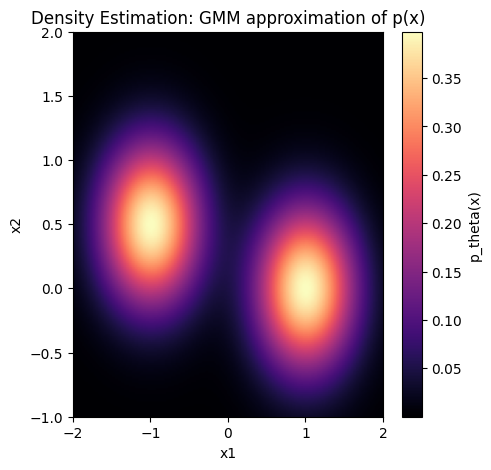

x=[0.0, 0.0] -> p_theta(x)=0.050143
x=[1.0, 0.20000000298023224] -> p_theta(x)=0.360038
x=[-1.0, 0.6000000238418579] -> p_theta(x)=0.388071


In [ ]:
# Density Estimation Demo with a Gaussian Mixture Model (GMM)
# -----------------------------------------------------------
# Task: Show how density estimation works
#   Input: a point x
#   Output: the model's estimated probability density p_theta(x)

import torch
import matplotlib.pyplot as plt

# Simple 2-component GMM (just for demo)
weights = torch.tensor([0.5, 0.5])  # mixture weights
means = torch.tensor([[1.0, 0.0],   # roughly center of one moon
                      [-1.0, 0.5]]) # roughly center of the other moon
covs = torch.stack([
    0.2 * torch.eye(2),             # small covariance around first mean
    0.2 * torch.eye(2)              # small covariance around second mean
])

components = []
for k in range(2):
    comp = torch.distributions.MultivariateNormal(means[k], covariance_matrix=covs[k])
    components.append(comp)

def gmm_log_prob(x):
    # log-sum-exp across mixture components
    log_probs = []
    for k in range(2):
        logp = components[k].log_prob(x) + torch.log(weights[k])
        log_probs.append(logp.unsqueeze(-1))
    log_probs = torch.cat(log_probs, dim=-1)  # [..., K]
    return torch.logsumexp(log_probs, dim=-1)

def gmm_prob(x):
    return torch.exp(gmm_log_prob(x))

# --------------------------
# Evaluate on a grid
# --------------------------
x1 = torch.linspace(-2, 2, 200)
x2 = torch.linspace(-1, 2, 200)
X1, X2 = torch.meshgrid(x1, x2, indexing="ij")
grid_points = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=1)

with torch.no_grad():
    dens = gmm_prob(grid_points).reshape(X1.shape)

plt.figure(figsize=(5,5))
plt.imshow(dens.numpy().T, origin="lower", extent=[-2,2,-1,2], aspect="auto", cmap="magma")
plt.colorbar(label="p_theta(x)")
plt.title("Density Estimation: GMM approximation of p(x)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()

# --------------------------
# Show density estimation at a few probe points
# --------------------------
probe = torch.tensor([[0.0, 0.0],
                      [1.0, 0.2],
                      [-1.0, 0.6]])
for x in probe:
    print(f"x={x.tolist()} -> p_theta(x)={gmm_prob(x.unsqueeze(0)).item():.6f}")


step  500 | nll(u) 1.839
step 1000 | nll(u) 1.765
step 1500 | nll(u) 1.664
step 2000 | nll(u) 1.695
step 2500 | nll(u) 1.797
step 3000 | nll(u) 1.726


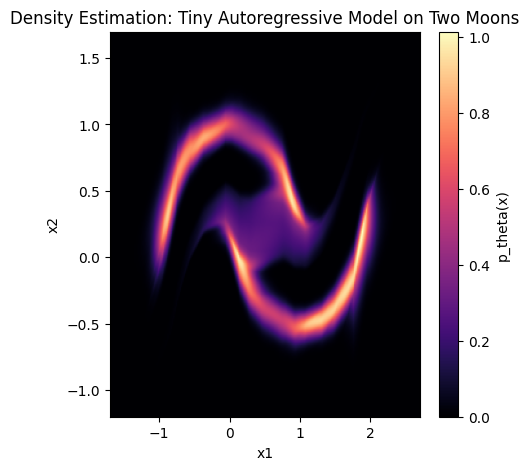

Density estimation p_theta(x) at probe points:
  x=[0.0, 0.0] -> p_theta(x)=0.102274
  x=[1.0, 0.20000000298023224] -> p_theta(x)=0.356197
  x=[-0.800000011920929, 0.8999999761581421] -> p_theta(x)=0.076818
  x=[1.7999999523162842, -0.20000000298023224] -> p_theta(x)=0.506265


In [ ]:
# Density Estimation on Two Moons with a Tiny Autoregressive Model (MAF-style)
# ----------------------------------------------------------------------------
# - If you've already run the "training data" cell, it will reuse `data_x`.
# - Otherwise, it will create the two-moons dataset here.
#
# Focus: DENSITY ESTIMATION (input x -> p_theta(x)), not sampling.

import math, torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --------------------------
# Two-moons data (reuse if available)
# --------------------------
try:
    data_x  # from a previous cell
except NameError:
    def sample_two_moons(n=6000, noise=0.07):
        theta1 = torch.rand(n//2) * math.pi
        moon1 = torch.stack([torch.cos(theta1), torch.sin(theta1)], dim=1)
        theta2 = torch.rand(n - n//2) * math.pi
        moon2 = torch.stack([1.0 - torch.cos(theta2), 1.0 - torch.sin(theta2) - 0.5], dim=1)
        X = torch.cat([moon1, moon2], dim=0)
        X += noise * torch.randn_like(X)
        return X
    data_x = sample_two_moons(6000, noise=0.07)

# Standardize for stability: u = (x - mu)/sigma
mu = data_x.mean(0)
sigma = data_x.std(0, unbiased=True).clamp_min(1e-3)
data_u = (data_x - mu) / sigma
data_u = data_u.to(device)

# --------------------------
# Tiny 2D MAF (autoregressive) for density estimation
# --------------------------
class Conditioner1D(nn.Module):
    """
    1D conditioner: maps a single scalar to (shift, log_scale) for the other dim.
    Bound log_scale via tanh*s_scale to keep exp(log_scale) finite.
    """
    def __init__(self, hidden=64, s_scale=2.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 2),
        )
        self.s_scale = s_scale

    def forward(self, x_scalar):  # shape [...,1]
        h = self.net(x_scalar)
        t = h[..., :1]
        s_raw = h[..., 1:]
        s = self.s_scale * torch.tanh(s_raw)
        return t, s

class AffineARLayer(nn.Module):
    """
    2D affine autoregressive layer.
    order='12': z1 = (x1 - t1) * exp(-s1);  z2 = (x2 - t2(x1)) * exp(-s2(x1))
    order='21': z2 = (x2 - t2) * exp(-s2);  z1 = (x1 - t1(x2)) * exp(-s1(x2))
    """
    def __init__(self, order='12', s_scale=2.0):
        super().__init__()
        assert order in ('12','21')
        self.order = order
        self.s_scale = s_scale
        # First variable: learn global shift/scale
        self.t_first = nn.Parameter(torch.zeros(1))
        self.s_first_raw = nn.Parameter(torch.zeros(1))
        # Second variable conditioned on the first
        self.cond = Conditioner1D(hidden=64, s_scale=s_scale)

    def forward(self, x, reverse=False):
        x1 = x[..., :1]
        x2 = x[..., 1:]
        s1 = self.s_scale * torch.tanh(self.s_first_raw)
        t1 = self.t_first

        if not reverse:
            if self.order == '12':
                z1 = (x1 - t1) * torch.exp(-s1)
                t2, s2 = self.cond(x1)
                z2 = (x2 - t2) * torch.exp(-s2)
                z = torch.cat([z1, z2], dim=-1)
                logdet = (-s1 - s2.squeeze(-1)).squeeze(-1)
            else:
                z2 = (x2 - t1) * torch.exp(-s1)
                t1c, s1c = self.cond(x2)
                z1 = (x1 - t1c) * torch.exp(-s1c)
                z = torch.cat([z1, z2], dim=-1)
                logdet = (-s1 - s1c.squeeze(-1)).squeeze(-1)
            return z, logdet
        else:
            if self.order == '12':
                z1 = x1; z2 = x2
                x1_rec = t1 + torch.exp(s1) * z1
                t2, s2 = self.cond(x1_rec)
                x2_rec = t2 + torch.exp(s2) * z2
                x_rec = torch.cat([x1_rec, x2_rec], dim=-1)
                logdet = (s1 + s2.squeeze(-1)).squeeze(-1)
            else:
                z1 = x1; z2 = x2
                x2_rec = t1 + torch.exp(s1) * z2
                t1c, s1c = self.cond(x2_rec)
                x1_rec = t1c + torch.exp(s1c) * z1
                x_rec = torch.cat([x1_rec, x2_rec], dim=-1)
                logdet = (s1 + s1c.squeeze(-1)).squeeze(-1)
            return x_rec, logdet

class TinyMAF2D(nn.Module):
    def __init__(self, s_scale=2.0):
        super().__init__()
        self.l1 = AffineARLayer(order='12', s_scale=s_scale)
        self.l2 = AffineARLayer(order='21', s_scale=s_scale)
        self.base = torch.distributions.MultivariateNormal(
            torch.zeros(2, device=device), torch.eye(2, device=device))

    def f(self, u):
        z, ld1 = self.l1(u, reverse=False)
        z, ld2 = self.l2(z, reverse=False)
        return z, (ld1 + ld2)

    def f_inv(self, z):
        x, ld2 = self.l2(z, reverse=True)
        x, ld1 = self.l1(x, reverse=True)
        return x, (ld1 + ld2)

    # Log-prob in standardized space u
    def log_prob_u(self, u):
        z, logdet = self.f(u)
        return self.base.log_prob(z) + logdet

    # Log-prob in original x-space (change of variables)
    def log_prob_x(self, x):
        u = (x - mu.to(x.device)) / sigma.to(x.device)
        const = -torch.log(sigma.to(x.device)).sum()  # det|diag(sigma)| term
        return self.log_prob_u(u) + const

model = TinyMAF2D(s_scale=2.0).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

# --------------------------
# Train for density estimation (MLE)
# --------------------------
def train(steps=3000, bs=512):
    N = data_u.size(0)
    model.train()
    for step in range(1, steps+1):
        idx = torch.randint(0, N, (bs,), device=device)
        u = data_u[idx]
        nll = -model.log_prob_u(u).mean()
        opt.zero_grad(set_to_none=True)
        nll.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        if step % 500 == 0:
            print(f"step {step:4d} | nll(u) {nll.item():.3f}")

train(steps=3000, bs=512)

# --------------------------
# Visualize p_theta(x) as a heatmap (density estimation)
# --------------------------
with torch.no_grad():
    x1min = max(-3.0, float(data_x[:,0].min()) - 0.5)
    x1max = min( 3.0, float(data_x[:,0].max()) + 0.5)
    x2min = max(-3.0, float(data_x[:,1].min()) - 0.5)
    x2max = min( 3.0, float(data_x[:,1].max()) + 0.5)
    g1 = torch.linspace(x1min, x1max, 240)
    g2 = torch.linspace(x2min, x2max, 240)
    X1, X2 = torch.meshgrid(g1, g2, indexing='ij')
    Gx = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=1)

    chunk = 8192
    lps = []
    for i in range(0, Gx.size(0), chunk):
        gx = Gx[i:i+chunk].to(device)
        lp = model.log_prob_x(gx).detach().cpu()
        lps.append(lp)
    lp_grid = torch.cat(lps, dim=0).reshape(X1.shape)
    dens = torch.exp(lp_grid)

plt.figure(figsize=(5,5))
plt.imshow(dens.numpy().T, origin='lower',
           extent=[x1min, x1max, x2min, x2max], aspect='auto', cmap='magma')
plt.colorbar(label="p_theta(x)")
plt.title("Density Estimation: Tiny Autoregressive Model on Two Moons")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()

# --------------------------
# Probe densities at a few points
# --------------------------
probe = torch.tensor([[0.0, 0.0],
                      [1.0, 0.2],
                      [-0.8, 0.9],
                      [1.8, -0.2]], dtype=torch.float32)
with torch.no_grad():
    vals = []
    for i in range(0, probe.size(0), 64):
        lp = model.log_prob_x(probe[i:i+64].to(device)).cpu()
        vals.append(lp)
    pv = torch.exp(torch.cat(vals)).tolist()

print("Density estimation p_theta(x) at probe points:")
for x_, v in zip(probe.tolist(), pv):
    print(f"  x={x_} -> p_theta(x)={v:.6f}")


2. **Sampling / Generation**  
   - **Input:** nothing (just random noise from a base distribution)  
   - **Output:** a new data point $x' \sim p_\theta$  
   - *Use case:* generating realistic data, simulation, creativity  



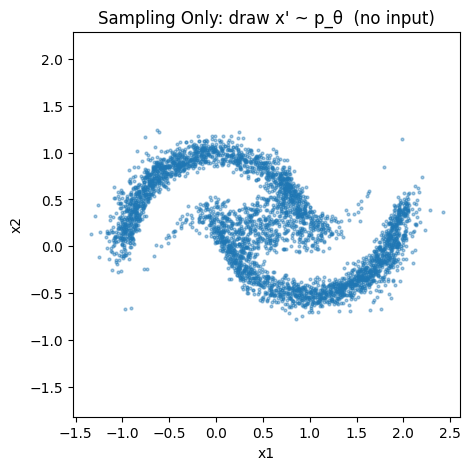

Sampling demo complete: generated 4000 points from the learned p_θ (no input).


In [ ]:
# Sampling Only: draw x' ~ p_θ (robust to prior model definitions)
# ---------------------------------------------------------------
# Works whether your existing TinyMAF2D has `sample_u` or not.
# If no trained model (or mu/sigma) is present, it will quick-train one.

import math, torch, torch.nn as nn
import matplotlib.pyplot as plt

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---------- Utilities ----------
def sample_two_moons(n=6000, noise=0.07):
    theta1 = torch.rand(n//2) * math.pi
    m1 = torch.stack([torch.cos(theta1), torch.sin(theta1)], dim=1)
    theta2 = torch.rand(n - n//2) * math.pi
    m2 = torch.stack([1.0 - torch.cos(theta2), 1.0 - torch.sin(theta2) - 0.5], dim=1)
    X = torch.cat([m1, m2], dim=0)
    X += noise * torch.randn_like(X)
    return X

# TinyMAF2D pieces (only defined if we need to quick-train)
class Conditioner1D(nn.Module):
    def __init__(self, hidden=64, s_scale=2.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 2),
        )
        self.s_scale = s_scale
    def forward(self, x1):
        h = self.net(x1)
        t = h[..., :1]
        s = self.s_scale * torch.tanh(h[..., 1:])
        return t, s

class AffineARLayer(nn.Module):
    def __init__(self, order='12', s_scale=2.0):
        super().__init__()
        assert order in ('12','21')
        self.order = order
        self.t_first = nn.Parameter(torch.zeros(1))
        self.s_first_raw = nn.Parameter(torch.zeros(1))
        self.s_scale = s_scale
        self.cond = Conditioner1D(hidden=64, s_scale=s_scale)
    def forward(self, x, reverse=False):
        x1, x2 = x[..., :1], x[..., 1:]
        s1 = self.s_scale * torch.tanh(self.s_first_raw)
        t1 = self.t_first
        if not reverse:
            if self.order == '12':
                z1 = (x1 - t1) * torch.exp(-s1)
                t2, s2 = self.cond(x1)
                z2 = (x2 - t2) * torch.exp(-s2)
                z  = torch.cat([z1, z2], dim=-1)
                logdet = (-s1 - s2.squeeze(-1)).squeeze(-1)
            else:
                z2 = (x2 - t1) * torch.exp(-s1)
                t1c, s1c = self.cond(x2)
                z1 = (x1 - t1c) * torch.exp(-s1c)
                z  = torch.cat([z1, z2], dim=-1)
                logdet = (-s1 - s1c.squeeze(-1)).squeeze(-1)
            return z, logdet
        else:
            if self.order == '12':
                z1, z2 = x1, x2
                x1r = t1 + torch.exp(s1) * z1
                t2, s2 = self.cond(x1r)
                x2r = t2 + torch.exp(s2) * z2
                xr  = torch.cat([x1r, x2r], dim=-1)
                logdet = (s1 + s2.squeeze(-1)).squeeze(-1)
            else:
                z1, z2 = x1, x2
                x2r = t1 + torch.exp(s1) * z2
                t1c, s1c = self.cond(x2r)
                x1r = t1c + torch.exp(s1c) * z1
                xr  = torch.cat([x1r, x2r], dim=-1)
                logdet = (s1 + s1c.squeeze(-1)).squeeze(-1)
            return xr, logdet

class TinyMAF2D(nn.Module):
    def __init__(self, s_scale=2.0):
        super().__init__()
        self.l1 = AffineARLayer(order='12', s_scale=s_scale)
        self.l2 = AffineARLayer(order='21', s_scale=s_scale)
        self.base = torch.distributions.MultivariateNormal(
            torch.zeros(2, device=device), torch.eye(2, device=device))
    def f_inv(self, z):
        x, ld2 = self.l2(z, reverse=True)
        x, ld1 = self.l1(x, reverse=True)
        return x, (ld1 + ld2)

# Helper that works whether or not model.sample_u exists
def sample_u_from_model(model, n):
    if hasattr(model, "sample_u") and callable(getattr(model, "sample_u")):
        return model.sample_u(n).cpu()
    # Fall back: use model.base + f_inv
    assert hasattr(model, "base") and hasattr(model, "f_inv"), \
        "Model missing base or f_inv for sampling."
    z = model.base.sample((n,))
    u, _ = model.f_inv(z)
    return u.detach().cpu()

# ---------- Ensure we have a trained model + mu/sigma ----------
needs_training = False
if 'model' not in globals() or 'mu' not in globals() or 'sigma' not in globals():
    needs_training = True

if needs_training:
    # Quick train so we can sample
    data_x = sample_two_moons(6000, noise=0.07)
    mu = data_x.mean(0)
    sigma = data_x.std(0, unbiased=True).clamp_min(1e-3)
    data_u = ((data_x - mu) / sigma).to(device)

    model = TinyMAF2D(s_scale=2.0).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    N = data_u.size(0)
    model.train()
    for step in range(1, 1501):
        idx = torch.randint(0, N, (512,), device=device)
        u = data_u[idx]
        # log p_U(u) = log p_Z(f(u)) + log|det J|
        z1, ld1 = model.l1(u, reverse=False)
        z2, ld2 = model.l2(z1, reverse=False)
        nll = -(model.base.log_prob(z2) + ld1 + ld2).mean()
        opt.zero_grad(set_to_none=True)
        nll.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        if step % 300 == 0:
            print(f"[quick-train] step {step:4d} | nll(u) {nll.item():.3f}")
    model.eval()

# ---------- SAMPLING: no input -> x' ~ p_θ ----------
with torch.no_grad():
    n_samples = 4000
    u_samples = sample_u_from_model(model, n_samples)  # standardized space
    x_samples = u_samples * sigma + mu                # de-standardize

plt.figure(figsize=(5,5))
plt.scatter(x_samples[:,0].numpy(), x_samples[:,1].numpy(), s=4, alpha=0.4)
plt.title("Sampling Only: draw x' ~ p_θ  (no input)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.axis("equal")
plt.show()

print("Sampling demo complete: generated", n_samples, "points from the learned p_θ (no input).")



👉 Even though both come from the same model $p_\theta$, these are **different computational problems**.  
- Density estimation requires evaluating the model at a given point.  
- Sampling requires transforming noise into new data.  

This separation is what makes generative modeling powerful **but also challenging**.

![Generative models](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*t71m2yZof-dfVB0L)

## Generative Modeling: Explicit vs. Implicit

![Generative models taxonomy](https://velog.velcdn.com/images/onground/post/07cf390e-ffd0-4f3e-a831-ded99d618cd9/image.png)

- **Explicit density models** allow both:
  - **Density estimation**: compute likelihood $p_\theta(x)$
  - **Sampling**: draw new samples $x' \sim p_\theta$
- **Implicit models** focus only on:
  - **Sampling** realistically, without providing an explicit density for evaluation.

## 🚧 Challenges of Deep Generative Modeling

Deep generative models aim to learn the **joint distribution** of high-dimensional data:

- **Grayscale example (MNIST):**  
  Each pixel is a Bernoulli random variable.  
  $$
  28 \times 28 = 784 \quad \text{variables}
  $$

- **Color example (ImageNet):**  
  Each pixel has 3 channels (RGB).  
$$
  224 \times 224 \times 3 = 150{,}528 \quad \text{variables}$$  
  That’s **~200× more variables** than MNIST!

---

### Visual Examples

**MNIST (784 variables):**  
![MNIST digit example](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

**ImageNet (150,528 variables):**  
![ImageNet example](https://ar5iv.labs.arxiv.org/html/1409.0575/assets/det_val_2012.png)

---

### Key Challenges

**High-Dimensional Joint Distributions**
   - From hundreds (MNIST) to hundreds of thousands (ImageNet) of variables.
   - Naïve modeling would require considering $256^{150,528}$ configurations for ImageNet!

**Computational & Statistical Efficiency**
   - Training at ImageNet scale is extremely expensive.
   - Models must learn effectively from finite data and compute budgets.


**Sampling Quality and Speed**
   - High-res samples must look realistic and diverse.
   - Fast sampling is critical (GANs vs autoregressive vs diffusion).

---



## 🎯 Motivation: Estimation by Counting

Recall: the goal of generative modeling is to **estimate a data distribution** from samples.

---

### Example Setup
- Suppose the samples take values in a **finite set**  
  $$\{1, 2, \dots, 100\}$$

- **Model:** a histogram, described by parameters  
  $$p_1, p_2, \dots, p_{100}, \quad \sum_{i=1}^{100} p_i = 1$$

---

### Training (Estimation)
- To train this model: **count frequencies** in the data  
  $$\hat{p}_i = \frac{\text{count of samples equal to } i}{\text{total number of samples}}$$

---

### Inference
- **Task:** given an observation $x=i$,  
  the probability estimate is simply  
  $$p(x=i) = \hat{p}_i$$  
  → just a **lookup** in the histogram.

---

### Sampling
- To generate a new sample:
  1. Draw an index $i \in \{1,\dots,100\}$ with probability $\hat{p}_i$.
  2. Output $x=i$.

---

✨ **Takeaway:**  
This is the simplest form of generative modeling:  
**estimate by counting** → inference by **lookup** → generation by **resampling** from the histogram.


## 🔎 Comments on the Histogram (Counting) Approach

### Advantages
1. **Simplicity**  
   - Easy to understand: estimate probabilities by counting frequencies.  
   - Inference is just a lookup table.  
   - Sampling is straightforward: resample from the histogram.

2. **Non-Parametric**  
   - Makes no assumptions about the underlying distribution.  
   - Works for any finite discrete domain.

---

### Limitations
1. **Data Inefficiency**  
   - Requires a large number of samples to estimate probabilities accurately.  
   - Sparse bins (rare events) may never be observed.

2. **No Generalization**  
   - Unseen events get probability 0.  
   - Fix: apply **smoothing** (e.g., Laplace/add-$\alpha$).

3. **Scalability Issues**  
   - Number of parameters grows with domain size.  
   - Example: for $|X| = 100$, need 100 parameters.  
   - For images ($28 \times 28 = 784$ pixels, each with 256 values), the space explodes to $256^{784}$ configurations!

4. **No Structural Knowledge**  
   - Treats each outcome as unrelated.  
   - Does not exploit correlations between parts of $x$ (e.g., neighboring pixels in images).

---

✨ **Takeaway:**  
Histogram models are a **useful starting point** for generative modeling, but they **don’t scale** to high-dimensional data.  
This motivates more powerful models (n-grams, autoregressive models, VAEs, flows, diffusion) that can generalize and share statistical strength.


## 📝 Autoregressive Models

Generative language models define **probability distributions over sequences** of words.  
They let us answer: *How likely is a sentence in a language?*

---

### Sentence Probability via the Chain Rule

The probability of a sequence $Y = (w_1, w_2, \dots, w_T)$ is factorized as:

$$
P(Y) = P(w_1, w_2, \dots, w_T)
     = \prod_{t=1}^{T} P(w_t \mid w_{<t})
$$

- “What do pigs eat ?” → high probability  
- “Pigs eat what do ?” → near zero probability  




---
---

## 🔄 Approach: Left-to-Right Generation

Autoregressive models generate text **step by step**:  
each next word is predicted from the previous words.

**Analogy: Predictive Text (Google Search suggestions)**  

User types: **“What do pigs …”**

| Next word | Probability |
|-----------|-------------|
| eat       | 0.50 |
| like      | 0.30 |
| wear      | 0.01 |
| …         | …   |

- Step 1: The model **computes a probability distribution** over possible next words.  
- Step 2: The model **samples** (or chooses) from that distribution to continue the sentence.  





In [ ]:
import random

# Toy probability distribution for "What do pigs ..."
dist = {"eat": 0.5, "like": 0.3, "wear": 0.01, "play": 0.19}

def sample_next(dist, seed=None):
    rng = random.Random(seed)
    words, probs = zip(*dist.items())
    return rng.choices(words, weights=probs, k=1)[0]

# Show multiple completions
for s in [1, 2, 3, 4, 5]:
    next_word = sample_next(dist, seed=s)
    print(f"What do pigs {next_word} ...")


What do pigs eat ...
What do pigs play ...
What do pigs eat ...
What do pigs eat ...
What do pigs like ...


## 📚 N-gram Language Models

### Core Idea
We want to compute the probability of a sequence of words:

$$
P(w_1, w_2, \dots, w_T) = \prod_{t=1}^{T} P(w_t \mid w_{<t})
$$

An **n-gram model** approximates the conditional probability using only the **last $n-1$ words**:

$$
P(w_t \mid w_{<t}) \;\approx\; P(w_t \mid w_{t-n+1}, \dots, w_{t-1})
$$

---

### Example: Sentence Probability

For the sentence *“what do pigs eat ?”*:

$$
P(\text{what do pigs eat ?})
= P(? \mid \text{what do pigs eat}) \cdot P(\text{eat} \mid \text{what do pigs}) \cdot P(\text{pigs} \mid \text{what do}) \cdot P(\text{do} \mid \text{what}) \cdot P(\text{what})
$$

- **Unigram ($n=1$):** $P(w_t)$  
- **Bigram ($n=2$):** $P(w_t \mid w_{t-1})$  
- **Trigram ($n=3$):** $P(w_t \mid w_{t-2}, w_{t-1})$

---

### ⚠️ The Zero-Count Problem

What if we have never observed a phrase in the corpus?

- Example: $N(\text{“what do pigs”}) = 0$  
- Then $P(\text{“eat”} \mid \text{“what do pigs”})$ would be undefined.

**Solutions:**
1. **Laplace Smoothing (Add-$\alpha$):**  
   Add a small constant to all counts.  
   $$\hat{p}_\alpha(w \mid h) = \frac{C(h, w) + \alpha}{C(h) + \alpha V}$$

2. **Backoff:**  
   If an $n$-gram has zero count, back off to a shorter history.  
   Example: fall back from trigram $\to$ bigram $\to$ unigram.

3. **Linear Interpolation:**  
   Combine different $n$-gram models with weights $\lambda$:  
   $$P = \lambda_1 P_{\text{unigram}} + \lambda_2 P_{\text{bigram}} + \lambda_3 P_{\text{trigram}}$$

---

### Left-to-Right Generation

N-gram models are **left-to-right language models**.  
At each step, they predict a distribution for the next word:

- Input so far: **“What do pigs …”**  
- Model outputs probabilities for next word:

| Next word | Probability |
|-----------|-------------|
| eat       | 0.50 |
| like      | 0.30 |
| wear      | 0.01 |
| …         | …   |

**Steps:**
1. **Get probability distribution** $P(w_t \mid w_{t-n+1}, \dots, w_{t-1})$  
2. **Sample** (or choose) a next word from this distribution  
3. Repeat until sentence ends

---

✨ **Takeaway:**  
N-gram models are simple, interpretable, and easy to train.  
But they struggle with **zero counts**, **long-range dependencies**, and **scalability** — motivating more advanced models like RNNs, Transformers, and neural LMs.


## 🤖 Neural Autoregressive Models

### Problem with N-gram Models
- N-grams approximate $P(w_t \mid w_{<t})$ using only the last $n-1$ tokens.  
- This leads to:
  - **Data sparsity** (zero counts for rare phrases)  
  - **Limited context** (cannot capture long-range dependencies)  
  - **Scalability issues** (huge parameter tables for large vocabularies)

---

### Neural Approach
Instead of counting, we **train a neural network** to compute the conditional probabilities:

$$
P(w_t \mid w_{<t}) \;\approx\; \text{NeuralNet}(w_{<t})
$$

- **Input:** the context (all words before $t$)  
- **Output:** a probability distribution over the next token  

---

### How It Works
1. **Process the context**  
   - **RNNs (Recurrent Neural Networks):** read tokens one by one, keep a hidden state.  
   - **Masking-based Models (e.g., Transformers):** process all context in parallel, with masks to prevent looking ahead.

2. **Generate the next-word distribution**  
   - Neural network outputs logits → softmax → probability distribution.  
   - Example for *“what do pigs …”*:  
     - $P(\text{eat} \mid \text{what do pigs}) = 0.6$  
     - $P(\text{like} \mid \text{what do pigs}) = 0.2$  
     - $P(\text{wear} \mid \text{what do pigs}) = 0.01$  



## 🔤 Tokenization

**Definition:**  
Tokenization is the task of converting raw text (or code, or music) into a sequence of **discrete items**, called *tokens*, that can be processed by a model.

---

### Approaches to Tokenization

#### 1. Word-based Tokenization
- Treat each word as a token.  
- **Advantages:** intuitive, matches human notions of words.  
- **Challenges:**
  - Vocabulary can be extremely large (e.g., 260,000+ words).  
  - Rare or misspelled words collapse into "unknown" (`<UNK>`).  



---
---

#### 2. Character-based Tokenization
- Treat each character as a token.  
- **Advantages:** small vocabulary (e.g., 256 characters in ASCII).  
- **Challenges:**
- Longer sequences (each word = multiple tokens).  
- Harder to learn semantic meaning across long contexts.  



---

### (Later) Subword-based Tokenization
- Hybrid approach (e.g., BPE, WordPiece, SentencePiece).  
- Balances vocabulary size and flexibility.  
- Widely used in modern LMs (e.g., GPT, BERT, T5).  

---

✨ **Takeaway:**  
Tokenization defines the **model’s input space**.  
Choosing between word, character, or subword tokens directly affects:
- **Vocabulary size**  
- **Ability to handle rare words**  
- **Sequence length and learning difficulty**


In [7]:
# Short demo: Word-based vs Character-based vs Subword-based
# ----------------------------------------------------------

import re
from transformers import AutoTokenizer

text = "What do pigs eat? Zebrasynthesized words like flibbertigibbet!"

print("INPUT TEXT:\n", text)
print("="*80)

# --- 1) WORD-BASED TOKENIZATION (simple whitespace/punctuation split) ---
def word_tokenize(s):
    return re.findall(r"[A-Za-z0-9']+|[^\sA-Za-z0-9']", s)

tokens_word = word_tokenize(text)
print("WORD-BASED TOKENS:")
print(tokens_word)
print(f"Count = {len(tokens_word)}")
print("-"*80)

# --- 2) CHARACTER-BASED TOKENIZATION ---
tokens_char = list(text)
print("CHARACTER-BASED TOKENS (first 50 shown):")
print(tokens_char[:50], "..." if len(tokens_char) > 50 else "")
print(f"Count = {len(tokens_char)}")
print("-"*80)

# --- 3) SUBWORD-BASED TOKENIZATION (GPT-2 BPE) ---
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")
sub_tokens = tokenizer.tokenize(text)
print("SUBWORD-BASED TOKENS:")
print(sub_tokens)
print(f"Count = {len(sub_tokens)}")
print("-"*80)

# --- Comparison Summary ---
print("SUMMARY:")
print(f"- Word-based: {len(tokens_word)} tokens")
print(f"- Char-based: {len(tokens_char)} tokens")
print(f"- Subword-based (WordPiece): {len(sub_tokens)} tokens")


INPUT TEXT:
 What do pigs eat? Zebrasynthesized words like flibbertigibbet!
WORD-BASED TOKENS:
['What', 'do', 'pigs', 'eat', '?', 'Zebrasynthesized', 'words', 'like', 'flibbertigibbet', '!']
Count = 10
--------------------------------------------------------------------------------
CHARACTER-BASED TOKENS (first 50 shown):
['W', 'h', 'a', 't', ' ', 'd', 'o', ' ', 'p', 'i', 'g', 's', ' ', 'e', 'a', 't', '?', ' ', 'Z', 'e', 'b', 'r', 'a', 's', 'y', 'n', 't', 'h', 'e', 's', 'i', 'z', 'e', 'd', ' ', 'w', 'o', 'r', 'd', 's', ' ', 'l', 'i', 'k', 'e', ' ', 'f', 'l', 'i', 'b'] ...
Count = 62
--------------------------------------------------------------------------------


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

SUBWORD-BASED TOKENS:
['What', 'Ġdo', 'Ġpigs', 'Ġeat', '?', 'ĠZe', 'br', 'asy', 'nt', 'hes', 'ized', 'Ġwords', 'Ġlike', 'Ġfl', 'ib', 'bert', 'ig', 'ib', 'bet', '!']
Count = 20
--------------------------------------------------------------------------------
SUMMARY:
- Word-based: 10 tokens
- Char-based: 62 tokens
- Subword-based (WordPiece): 20 tokens


## 🔄 From Tokens to Embedding Vectors

**Pipeline:**

1. **Tokenizer**  
   Raw text → split into tokens  
   Example:  
"What do pigs eat?"
→ ['what', 'do', 'pigs', 'eat', '?']


2. **Convert to Token IDs**  
Each token is mapped to an integer ID from the vocabulary.  
Example:  
['what', 'do', 'pigs', 'eat', '?']
→ [2054, 2079, 14205, 4521, 1029]



3. **Embedding Lookup**  
Each ID is mapped to a dense vector from the **embedding matrix**:  

$$
\text{EmbeddingMatrix} \in \mathbb{R}^{V \times d}, \quad
e_i = \text{EmbeddingMatrix}[\,\text{$token\_id$}=i\,]
$$

- $V$ = vocabulary size (e.g., 50,257 for BERT)  
- $d$ = embedding dimension (e.g., 768 for GPT2/BERT-base)  

Example:  
- "what" (id=2054) → $e_{2054} \in \mathbb{R}^{768}$  
- "pigs" (id=14205) → $e_{14205} \in \mathbb{R}^{768}$  

---

✨ **Result:**  
The input sentence becomes a **matrix of embeddings** of shape  
`(sequence_length, embedding_dim)` → one vector per token.

In [10]:
import torch
from transformers import AutoTokenizer, AutoModel

# Load pretrained GPT-2 tokenizer + model
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModel.from_pretrained("gpt2")

# Input sentence
text = "What do pigs eat?"

# Step 1: Tokenize → IDs
enc = tokenizer(text, return_tensors="pt")
tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0].tolist())
print("Tokens:", tokens)
print("Token IDs:", enc["input_ids"][0].tolist())

# Step 2: Embedding lookup via model
with torch.no_grad():
    outputs = model(**enc)
    embeddings = outputs.last_hidden_state  # shape: [batch, seq_len, hidden_dim]

print("\nEmbeddings shape:", embeddings.shape)
print(f"Vector for token '{tokens[0]}' (first 10 dims):")
print(embeddings[0,0,:10])
print(embeddings[0,0].shape)



Tokens: ['What', 'Ġdo', 'Ġpigs', 'Ġeat', '?']
Token IDs: [2061, 466, 22333, 4483, 30]

Embeddings shape: torch.Size([1, 5, 768])
Vector for token 'What' (first 10 dims):
tensor([-0.1643,  0.0957, -0.2844,  0.0323, -0.2422, -0.1769, -0.5323, -0.0690,
        -0.2071,  0.0802])
torch.Size([768])


## ⚙️ Training Pipeline for Neural Autoregressive Models

### 1. Forward Pass
We want to model the probability of the next token $y_T$ given the previous tokens $y_{<T}$.

1. **Embedding layer**  
   Each token $y_t$ (ID) is mapped to a dense vector:  
   $$
   e_t = \text{EmbeddingMatrix}[y_t] \in \mathbb{R}^d
   $$

2. **Context representation**  
   Feed embeddings of the previous tokens $(e_1, e_2, \dots, e_{T-1})$ into a neural network (RNN, Transformer, etc.) to get a hidden representation of the context:  
   $$
   h_{T-1} = f_\theta(e_1, e_2, \dots, e_{T-1})
   $$

3. **Next-token distribution**  
   From $h_{T-1}$, predict the probability distribution for the next word $y_T$:  
   $$
   p_\theta(y_T \mid y_{<T}) = \text{Softmax}(W h_{T-1} + b)
   $$

---

### 2. Training Objective
When evaluating language models, we want to measure **how well the predicted distribution $q$ matches the true data distribution $p$.**

---

### Cross-Entropy
The **cross-entropy** between the data distribution $p$ and the model $q$ is:

$$
H(p, q) = -\frac{1}{N} \sum_{t=1}^N \log q(w_t \mid w_{<t})
$$

- $N$: number of tokens in the test sequence  
- $w_t$: the $t$-th token  
- $w_{<t}$: all tokens before position $t$  
- $q(w_t \mid w_{<t})$: the probability assigned by the model  

---


### Relation to KL Divergence
Cross-entropy is related to the **[Kullback–Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)**:

$$
H(p, q) = H(p) + D_{\mathrm{KL}}(p \;\|\; q)
$$

- $H(p)$: entropy of the true distribution (constant w.r.t. the model)  
- $D_{\mathrm{KL}}(p \;\|\; q)$: penalty for how far $q$ is from $p$  

Thus, minimizing cross-entropy (and perplexity) is equivalent to minimizing the KL divergence.

---

### Perplexity
The **perplexity (PP)** of a model is the exponential of the cross-entropy:

$$
\text{PP}(q) = \exp\!\Big(H(p,q)\Big)
= \exp\!\left(-\frac{1}{N}\sum_{t=1}^N \log q(w_t \mid w_{<t})\right)
$$

---
### Interpretation
- Perplexity can be understood as the **effective average branching factor** of the model.  
- A **lower perplexity** means the model is less “perplexed” → better predictions.  
- A **higher perplexity** means the model is more “confused” → worse predictions.  

**Examples:**
- Perfect model → $\text{PP} = 1$  
- Uniform distribution over $V$ tokens → $\text{PP} = V$


---

### 🔑 Intuition
- **Forward pass:** Context → hidden representation → predicted distribution.  
- **Training:** Use cross-entropy loss to align predicted probabilities with the true next token.  
- **Result:** The model learns parameters $\theta$ that maximize the likelihood of the training corpus.


## 🎲 Decoding / Inference in Language Models

After training, a language model gives us a **probability distribution** for the next token:  

Example (given context *“What do pigs …”*):  

| Next word | Probability |
|-----------|-------------|
| eat       | 0.50 |
| like      | 0.30 |
| wear      | 0.01 |
| …         | …   |

The challenge: **How do we turn this distribution into actual text?**

---

### 1. Argmax (Greedy Decoding)
Choose the most likely token:
$$
w_t = \arg\max_{w} p_\theta(w \mid w_{<t})
$$
- Deterministic, always picks the top token.  
- Can lead to repetitive or dull text.

---

### 2. Random Sampling
Draw a token at random according to probabilities:
$$
w_t \sim p_\theta(\cdot \mid w_{<t})
$$
- Introduces diversity.  
- Can produce incoherent results if low-probability tokens are sampled.

---

### 3. Sampling with Temperature
Rescale probabilities before sampling:
$$
p_T(w) = \frac{p(w)^{1/T}}{\sum_{w'} p(w')^{1/T}}
$$
- $T < 1$: sharper distribution (more deterministic).  
- $T > 1$: flatter distribution (more random).

---

### 4. Top-k Sampling
Restrict sampling to the **k most probable tokens**.  
- Reduces chance of sampling very unlikely words.  
- Example: $k=5$ → only sample among top 5 tokens.

---

### 5. Top-p Sampling (Nucleus Sampling)
Choose the smallest set of tokens whose cumulative probability ≥ $p$, then sample from this set.  
- Adaptive: the number of candidates varies by context.  
- Example: with $p=0.9$, keep only tokens that together make up 90% of the probability mass.

---

### 6. Beam Search
Explore multiple candidate continuations at once, keeping the top $B$ beams:
- At each step, expand all beams with possible next tokens.  
- Keep the $B$ most likely partial sequences.  
- Often used in machine translation and summarization.

---

✨ **Takeaway:**  
Different decoding strategies balance **determinism vs diversity**.  
- **Greedy/Beam:** more accurate but less diverse.  
- **Random/Temperature/Top-k/Top-p:** more diverse but can risk coherence.


## Greedy vs Global Maximum Likelihood in Sampling

Greedy decoding chooses the most likely token at each step, but this does not always yield the **globally most likely sequence**.

---

### Setup
Suppose a language model assigns probabilities to words in a sequence.  
The goal is to maximize the **joint probability**:

$$
P(w_1, w_2, \ldots, w_T) = \prod_{t=1}^T P(w_t \mid w_{<t}).
$$

---

### Counterexample (where greedy fails)

- **Step 1**:  
  - `A`: 0.6  
  - `B`: 0.4  

- **Step 2**:  
  - If `A`:  
    - `x`: 0.4  
    - `y`: 0.6  
  - If `B`:  
    - `x`: 0.95  
    - `y`: 0.05  

---

#### Greedy decoding
- Step 1: choose `A` (0.6).  
- Step 2: choose `y` (0.6).  
- Sequence = **`A y`**  
  $$
  P(Ay) = 0.6 \times 0.6 = 0.36
  $$

#### Global maximum
- Sequence `B x`:  
  $$
  P(Bx) = 0.4 \times 0.95 = 0.38
  $$

---

### Conclusion
- Greedy decoding produces `A y` with probability **0.36**.  
- The globally optimal sequence is `B x` with probability **0.38**.  

✅ Greedy failed to find the maximum likelihood sequence.  
This is why **beam search** or **sampling** is often preferred over greedy decoding.


## 🔎 Beam Search for Decoding

### Assumption
The best sequence $Y = (w_1, w_2, \dots, w_T)$ is the one with the **highest overall likelihood**:
$$
Y^* = \arg\max_{Y} P(Y) = \arg\max_{Y} \prod_{t=1}^T P(w_t \mid w_{<t})
$$

But:  
- The search space grows exponentially with sequence length.  
- Exact search is **intractable**.

---

### Idea: Beam Search
Beam search is a **heuristic search algorithm** that approximates the most likely sequence.

**Algorithm:**
1. Start with the beginning token (e.g., `<bos>`).  
2. At each step, expand each partial sequence with **all possible next tokens**.  
3. Compute sequence scores (usually log-probabilities):  
   $$
   \text{score}(Y) = \sum_{t=1}^T \log P(w_t \mid w_{<t})
   $$
4. Keep only the **top $B$ sequences** (the beam), where $B$ = beam width.  
5. Repeat until end-of-sequence token `<eos>` is generated or max length reached.  
6. Return the highest-scoring sequence(s).

---

### Example (Beam width = 2)
- Step 1: Start with `<bos>`.  
- Step 2: Expand into candidates with probabilities. Keep top 2.  
- Step 3: Expand those 2 further. Keep top 2.  
- Continue until `<eos>`.  

Result: we explore a small subset of possible sequences, but more thoroughly than greedy decoding.

![Beam 2 example](https://towardsdatascience.com/wp-content/uploads/2021/04/1tEjhWqUgjX37VnT7gJN-4g.png)

---

### Pros
- Often yields better sequences than greedy decoding.  
- Still computationally efficient compared to exhaustive search.  
- Widely used in **machine translation**, **summarization**, **speech recognition**.

---

### Cons / Problems
- **Non-creative:** tends to produce generic, high-probability sequences.  
- **Bias toward short sequences:** since multiplying probabilities reduces with length.  
  - Fix: length normalization in scoring.  
- **Mode-seeking behavior:** ignores diversity, may miss alternative valid outputs.  
- **Computational cost:** grows with beam size $B$.

---

✨ **Takeaway:**  
Beam search is a **greedy approximation** to the maximum-likelihood decoding problem.  
It balances **quality vs efficiency**, but sacrifices **diversity and creativity** compared to sampling-based methods.


## 🤔 How Can We Choose Models?

### Starting Point: Two Variables
Suppose we have two random variables $y_1$ and $y_2$.  
A simple factorization is:

$$
p(y_1, y_2) = p(y_1)\, p(y_2 \mid y_1)
$$

- $p(y_1)$: marginal distribution of the first variable.  
- $p(y_2 \mid y_1)$: conditional distribution of the second given the first.  

This works nicely in low dimensions.

---

### Extending to Higher Dimensions
For $d$ random variables $(y_1, y_2, \dots, y_d)$, the chain rule gives:

$$
p(y_1, y_2, \dots, y_d) = \prod_{i=1}^d p(y_i \mid y_{<i})
$$

- In principle, this only requires **$O(d)$ conditional distributions**.  
- Each conditional can be estimated separately.

---

### Challenges in High Dimensions
1. **Large $d$**  
   - When $d$ is very large (e.g., pixels in an image, tokens in a sequence), each conditional distribution becomes hard to estimate.  
   - Parameter count and data requirements grow quickly.

2. **Limited Generalization**  
   - Classical approaches (e.g., histogram-based conditionals) do not generalize well.  
   - Rare contexts → zero counts.

3. **No Information Sharing**  
   - Estimating each conditional separately ignores shared structure.  
   - Example: $p(y_i \mid y_{<i})$ for different $i$ may have similar patterns, but classical models cannot exploit this.

---

### Motivation for Neural Models
Neural autoregressive models (RNNs, Transformers, masked models) address these issues by:
- Sharing parameters across positions $i$.  
- Learning distributed representations of context.  
- Scaling to very high-dimensional data.



## ⏳ Recurrent Neural Networks (RNNs) and Gated Memory

### Why RNNs?
- **Feedforward Neural Networks (FNNs):** process inputs independently; no memory of past inputs.  
- **Problem:** When processing sequences, an FNN cannot capture dependencies across time.  
  - Example: a digit sequence like `00100110` — FNNs may learn local patterns, but fail to generalize across positions.  
  - Memoryless models cannot "remember" information from the beginning of a long sequence.  

**Solution:** introduce **feedback loops** and **time delays** → the network maintains an internal state.  
This defines a **Recurrent Neural Network (RNN):**  
$$
h_t = f_\theta(h_{t-1}, x_t), \quad y_t = g_\theta(h_t)
$$
- $h_t$: hidden state at time $t$ (contains memory).  
- $x_t$: input at time $t$.  
- $y_t$: output at time $t$.  


### RNN with Loops
- A recurrent neural network has a **loop** that allows information to flow from one time step to the next:  
  $$
  h_t = f_W(h_{t-1}, x_t)
  $$
  where:
  - $x_t$: input at time $t$  
  - $h_t$: hidden state at time $t$  
  - $f_W$: a neural network transformation with parameters $W$  

---

### Unrolling the Loop

- At time $t=1$:  
  $h_1 = f_W(h_0, x_1)$  
- At time $t=2$:  
  $h_2 = f_W(h_1, x_2)$  
- At time $t=3$:  
  $h_3 = f_W(h_2, x_3)$  

And so on, until time $T$.

![RNN](https://miro.medium.com/v2/resize:fit:627/1*go8PHsPNbbV6qRiwpUQ5BQ.png)

---

### Gated Memory: LSTMs and GRUs
- **Challenge with vanilla RNNs:**  
  Gradients vanish/explode when modeling long-term dependencies.  
- **Fix:** Introduce **gates** to control information flow.  
  - Long Short-Term Memory (LSTM, 1997 — Hochreiter & Schmidhuber)  
  - Gated Recurrent Unit (GRU, 2014 — Cho et al.)  

These networks include **gated states (memory cells)** that selectively keep, forget, or update information over long time horizons.

![MNIST digit example](https://miro.medium.com/max/1280/1*yBXV9o5q7L_CvY7quJt3WQ.png)

## 🔑 LSTM and GRU Formulas

### 1. Long Short-Term Memory (LSTM)

At each time step $t$, given input $x_t$ and previous hidden state $h_{t-1}$ and cell state $c_{t-1}$:

**Gates:**
$$
f_t = \sigma(W_f [h_{t-1}, x_t] + b_f) \quad \text{(forget gate)}
$$
$$
i_t = \sigma(W_i [h_{t-1}, x_t] + b_i) \quad \text{(input gate)}
$$
$$
o_t = \sigma(W_o [h_{t-1}, x_t] + b_o) \quad \text{(output gate)}
$$

**Candidate cell state:**
$$
\tilde{c}_t = \tanh(W_c [h_{t-1}, x_t] + b_c)
$$

**Update cell and hidden state:**
$$
c_t = f_t \odot c_{t-1} \;+\; i_t \odot \tilde{c}_t
$$
$$
h_t = o_t \odot \tanh(c_t)
$$

- $f_t, i_t, o_t$: gating vectors in $[0,1]$  
- $c_t$: long-term memory (cell state)  
- $h_t$: short-term memory (hidden state)  

---

### 2. Gated Recurrent Unit (GRU)

At each time step $t$, given input $x_t$ and previous hidden state $h_{t-1}$:

**Gates:**
$$
z_t = \sigma(W_z [h_{t-1}, x_t] + b_z) \quad \text{(update gate)}
$$
$$
r_t = \sigma(W_r [h_{t-1}, x_t] + b_r) \quad \text{(reset gate)}
$$

**Candidate hidden state:**
$$
\tilde{h}_t = \tanh(W_h [\, r_t \odot h_{t-1}, \, x_t] + b_h)
$$

**Update hidden state:**
$$
h_t = (1 - z_t) \odot h_{t-1} \;+\; z_t \odot \tilde{h}_t
$$

---

### ✨ Key Differences
- **LSTM:** maintains a separate **cell state $c_t$** and hidden state $h_t$, with three gates (forget, input, output).  
- **GRU:** merges the cell and hidden state into $h_t$, with only two gates (update, reset) → simpler and faster to train.  

---

### ✨ Why LSTMs/GRUs?
- Capture **long-range dependencies**.  
- Avoid gradient vanishing/exploding.  
- Achieved state-of-the-art results in **speech, handwriting, and translation**.  
- Foundation for modern sequence models, later surpassed by Transformers.

---

**Takeaway:**  
RNNs introduce memory via recurrence. LSTMs and GRUs add **gates** to make that memory **controllable and robust**, marking a key milestone in the history of deep learning.
